**EVALUATION OF GENERATED TEXT BY COMPARISION WITH ORIGINAL SENTENCES AND EVALUATING (a)TEXT LEXICAL DIVERSITY, (b)TEXT SEMANTIC FIDELITY AND (c)LABEL PRESERVATION. PLOTTING RESULTS AND POST-PREPROCESSING OF GENERATED DATA.**

---

# Load and Read  ORIGINAL and GENERATED sentences

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import csv
from sklearn.preprocessing import MinMaxScaler ##normalize eucliedean distance

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/results/'
# path_to_model = 'distilbert_augmented7/'
path_to_model = 'distilbert_augmented35_gpt4/'

augmented_dataset_preprocessed_file_path = f'{path}/{path_to_model}/generated_text_preprocessed.tsv'
augmented_dataset_preprocessed = pd.read_csv(augmented_dataset_preprocessed_file_path, sep='\t', header=None)
print(len(augmented_dataset_preprocessed))

reference_dataset = f'{path}{path_to_model}/reference_dataset.tsv'
reference_dataset = pd.read_csv(reference_dataset, sep='\t',header=None)
print(len(reference_dataset))

4660
4660


In [ ]:
# Valid question -- should it be evaluation on each emotions generated data or concatenated data of all generated emotions???

In [ ]:
original_text = reference_dataset[0].tolist()
generated_text = augmented_dataset_preprocessed[0].tolist()

In [ ]:
original_text[1001]

In [ ]:
generated_text[1001]

In [ ]:
category = None
if category == 'grief':
  label_number =16
elif category =='pride':
  label_number = 21
elif category == 'relief':
  label_number = 23
elif category == 'nervousness':
  label_number = 12

elif category == 'embarrassment':
  label_number =19
else:
  label_number = 'other' ## in case of other emotions here can be added

In [ ]:
## save comparision csv file to look and manually validate correctness
combined_data = list(zip(original_text, generated_text))

with open(f"{path}/{path_to_model}text_evaluation/comparision_file.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Original Text", "Generated Text"])  # headers
    writer.writerows(combined_data)

## save logs
log = f"Dataset: GoEmotion.\nEvaluation of generated text and comparision with original text.\n"
with open(f"{path}/{path_to_model}text_evaluation/log.txt", "w") as log_file:
  log_file.write(log)

In [ ]:
## rough estimate - every other or fourth sentenec pair
original_text = original_text[::4]
generated_text = generated_text[::4]

# Tokenization

In [ ]:
!pip install transformers
!pip install tokenizers

In [ ]:
#Let's tokenize orginal text sentences and generated text sentences
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize(text_list, tokenizer, max_length):
  tokenized = tokenizer(
      text_list,
      padding='max_length',
      max_length=max_length,
      truncation=True,
      return_tensors="tf"
  )
  return tokenized

max_length = 30
original_text_tokenized = tokenize(original_text, tokenizer, max_length)
generated_text_tokenized = tokenize(generated_text, tokenizer, max_length)

In [ ]:
##check tokenized -> tensors
original_text_tokenized['input_ids'][0]
generated_text_tokenized['input_ids'][0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([ 101, 1997, 2607, 2025, 1010, 1031, 2171, 1033, 1998, 1031, 2171,
       1033, 2020, 2485, 2814, 1010, 1998, 4312, 1010, 2002, 2351, 1999,
       2355, 1012,  102,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
log_message1 = "Pair of sentences tokenized into numeric vector representation"

#a. Evaluate lexical text diversity

In [ ]:
import math
from collections import Counter
import numpy as np

In [ ]:
def calculate_word_counts_and_ratios(original_sentence, generated_sentence):
    original_word_counts = len(original_sentence.split())
    generated_word_counts = len(generated_sentence.split())
    word_count_ratios = len(generated_sentence.split()) / len(original_sentence.split())

    return original_word_counts, generated_word_counts, word_count_ratios

# for original, generated in zip(original_text, generated_text):
#   original_word_counts,generated_word_counts, word_count_ratios =  calculate_word_counts_and_ratios(original, generated)
#   print(f"Original-Word Count: {original_word_counts}, Generated-Word Count: {generated_word_counts}, Word Count Ratio (Generated/Original): {word_count_ratios:.2f}")
#   print()


In [ ]:
##calculate jaccard dissimiliarity
def calculate_jaccard_dissimilarity(original_sentence, generated_sentence):

        original_tokens = set(original_sentence.split())
        generated_text_tokens = set(generated_sentence.split())
        intersection = len(original_tokens.intersection(generated_text_tokens))
        union = len(original_tokens) + len(generated_text_tokens) - intersection
        jaccard_dissimilarity = 1 - intersection / union
        return jaccard_dissimilarity

# for original, generated in zip(original_text, generated_text):
#   dissimilarity_jaccard = calculate_jaccard_dissimilarity(original, generated)
#   print(f"Jaccard dissimilarity index for Pair of sentences: {dissimilarity_jaccard:.4f}")

In [ ]:
## tokenization word level ( which is better for my task word level vs token level)
def calculate_information_entropy(original_sentence, generated_sentence):
  original_word_counts = Counter(original_sentence.split())
  # print("check, original_word_counts)
  generated_word_counts = Counter(generated_sentence.split())
  original_word_probabilities = [count / len(original_sentence.split()) for count in original_word_counts.values()]
  # print("check", original_word_probabilities)
  generated_word_probabilities = [count / len(generated_sentence.split()) for count in generated_word_counts.values()]
  entropy_original = -sum(p * math.log2(p) for p in original_word_probabilities)
  # print("check", entropy_original)
  entropy_generated = -sum(p * math.log2(p) for p in generated_word_probabilities)
  if entropy_original != 0:
      entropy_ratio = entropy_generated / entropy_original
  else:
      entropy_ratio = 0

  return entropy_ratio

# for original, generated in zip(original_text[:10], generated_text[:10]):
#   entropy_ratio = calculate_information_entropy(original, generated)
#   print(f"Entropy Ratio for Pair: {entropy_ratio:.4f}")

In [ ]:
# Vocabulary size and TTR -- on tokenized text -- what to do with tokens such 0 - padding, 101,102 CLS sep
def calculate_ttr(original_text_tokenized, generated_text_tokenized, index):
    original_tokens = np.array(original_text_tokenized["input_ids"][index])
    generated_tokens = np.array(generated_text_tokenized["input_ids"][index])
    original_vocabulary_size = len(set(original_tokens))       ##unique tokens length
    generated_vocabulary_size = len(set(generated_tokens)) ##unique tokens length
    original_ttr = original_vocabulary_size / len(original_tokens)
    generated_ttr = generated_vocabulary_size / len(generated_tokens)
    ttr_ratio = generated_ttr / original_ttr
    return ttr_ratio,  original_vocabulary_size, generated_vocabulary_size


# for i in range(len(original_text_tokenized["input_ids"])):
#     ttr_ratio, original_vocabulary_size, generated_vocabulary_size = calculate_ttr(original_text_tokenized, generated_text_tokenized, i)
#     print(f"Sentence Pair {i+1} - TTR Ratio: {ttr_ratio:.2f}, orginal - Vocab size: {original_vocabulary_size}, generated - Vocab size: {generated_vocabulary_size}")

In [ ]:
log_message2 = "Text lexical diversity measures: word_count and work_count_ratio, jaccard dissimalirity, entropy information, ttr"

#b. Evaluate semantic fidelity/similarity

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
# Load a pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
## how to perform tokenization as separate step and not inside method model.encode???????
## calculate cosine similarity using word embeddings
def calculate_cosine_similarity(original_sentence, generated_sentence, model):
    original_embeddings = model.encode(original_sentence, convert_to_tensor=True)
    generated_embeddings = model.encode(generated_sentence, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(original_embeddings, generated_embeddings)

    return cosine_scores

# for original, generated in zip(original_text, generated_text):
#   similarity_score = calculate_cosine_similarity(original, generated, model)
#   print(f'Cosine Similarity between pair of original and generated: {similarity_score.item():.4f}')

In [ ]:
## maybe normalize this euclidean distance results !!!?
def calculate_euclidean_distance(original_sentence, generated_sentence, index):
    original_token = np.array(original_sentence["input_ids"][index])
    generated_token = np.array(generated_sentence["input_ids"][index])

    distance = np.linalg.norm(generated_token - original_token)
    return distance


# for i in range(len(original_text_tokenized["input_ids"])):
#     euclidean_distance = calculate_euclidean_distance(original_text_tokenized, generated_text_tokenized, i)
#     print(f'euclidean_distance between pair {i+1} of orginal and generated text: {euclidean_distance:.4f}')


In [ ]:
!pip install transformers bert_score

In [ ]:
from bert_score import score

In [ ]:
## long time maybe add sub sample set to this??? but not in here but in function call below this code (while saving)
def calculate_bertscore(candidate, reference):
  # print(len(candidate))
  # print(len(reference))
  # P, R, F1 = score([candidate], [reference], model_type='bert-base-uncased')
  P, R, F1 = score([candidate], [reference], model_type='distilbert-base-uncased')
  return P.mean().item(), R.mean().item(), F1.mean().item()

# i=0
# # batch_original = original_text[:int(0.010*len(original_text))]
# # batch_paraphrased = paraphrased_text[:int(0.010*len(paraphrased_text))]
# for original, generated in zip(original_text, generated_text):
#   P, R, F1 = calculate_bertscore(generated, original)
#   print("Sentence pair of generated (predicted) and original (reference)")
#   print(f"BERTScore precision: {P:.4f}, BERTScore Recall: {R:.4f},BERTScore F1: {F1:.4f}")
#   print(); i +=1; print(f"{i}")

In [ ]:
log_message3 = "Semantic similarity measures - Cosine similarity (from embeddings model = SentenceTransformer('paraphrase-MiniLM-L6-v2')), Euclidean distance, BERTScore"

In [ ]:
log = f"log: {log_message1}\nlog2: {log_message2}\nlog3: {log_message3}\n"

with open(f"{path}/{path_to_model}text_evaluation/log.txt", "a") as log_file:
  log_file.write(log)

#Plotting and saving results

##results

lexical diversity:

-Word count in original and generated and Word ratio beetween them

-Calculate_jaccard_dissimilarity

-calculate_information_entropy

-calculate_ttr  with Tokenization with 'bert-base-uncased
____________________________________________________________________

semantic fidelity:

-cosine similarity using word embeddings with SentenceTransformer('paraphrase-MiniLM-L6-v2')

-euclidean_distance with Tokenization with 'bert-base-uncased

-bertscore

In [ ]:
##lexcial diversity function

from statistics import mean, median


def save_lexical_diversity_results(original_text, generated_text, filename):
  header = ['original text', 'generated text', 'original_word_counts','generated_word_counts', 'word_count_ratios','dissimilarity_jaccard',
            'entropy_ratio', 'ttr_ratio', 'original_vocabulary_size', 'generated_vocabulary_size']
  original_word_count_list = []; generated_word_count_list = []; word_count_ratio_list = [];dissimilarity_jaccard_list = []; entropy_ratio_list=[]; ttr_ratio_list= []
  i=0

  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)


    for original, generated in zip(original_text, generated_text):
      original_word_counts, generated_word_counts, word_count_ratios = calculate_word_counts_and_ratios(original, generated)
      original_word_count_list.append(original_word_counts)
      generated_word_count_list.append(generated_word_counts)
      word_count_ratio_list.append(word_count_ratios)

      dissimilarity_jaccard = calculate_jaccard_dissimilarity(original, generated)
      dissimilarity_jaccard_list.append(dissimilarity_jaccard)

      entropy_ratio = calculate_information_entropy(original, generated)
      entropy_ratio_list.append(entropy_ratio)

      ttr_ratio, original_vocabulary_size, generated_vocabulary_size = calculate_ttr(original_text_tokenized, generated_text_tokenized, i)
      i+=1
      ttr_ratio_list.append(ttr_ratio)

      writer.writerow([original, generated,original_word_counts, generated_word_counts, word_count_ratios,
                      dissimilarity_jaccard, entropy_ratio, ttr_ratio,original_vocabulary_size, generated_vocabulary_size])

    return original_word_count_list,generated_word_count_list, word_count_ratio_list, dissimilarity_jaccard_list, entropy_ratio_list, ttr_ratio_list

In [ ]:
diversity_filename=f'{path}{path_to_model}text_evaluation/lexical_diversity_results.csv'
original_word_count_list, generated_word_count_list,word_count_ratio_list, dissimilarity_jaccard_list, entropy_ratio_list, ttr_ratio_list=save_lexical_diversity_results(original_text, generated_text,diversity_filename )

avg_word_original_count = mean(original_word_count_list)
avg_word_generated_count = mean(generated_word_count_list)
avg_word_ratio_count = mean(word_count_ratio_list)
avg_diss_jaccard = mean(dissimilarity_jaccard_list)
avg_entropy = mean(entropy_ratio_list)
avg_ttr_ratio = mean(ttr_ratio_list)


In [ ]:
##semantic fidelity function

def save_semantic_fidelity_results(original_text, generated_text, filename):
  header = [ 'cosine_similarity', 'P(BERTScore)', 'R(BERTScore)', 'F1(BERTScore)']#,'euclidean_distance']
  cosine_similarity_list = []; F1_bertscore_list=[]# euclidean_distance_list=[];
  i=0

  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)


    for original, generated in zip(original_text, generated_text):
      # batch_original = original[:int(0.0010*len(original_text))]
      # batch_generated = generated[:int(0.0010*len(generated_text))]

      cosine_similarity = calculate_cosine_similarity(original , generated, model)
      cosine_similarity_list.append(cosine_similarity.item())


      P, R, F1 = calculate_bertscore(generated, original)
      F1_bertscore_list.append(F1)

      i+=1
      if i % 100 == 0:
        print(i)

      # euclidean_distance = calculate_euclidean_distance(original_text_tokenized, generated_text_tokenized, i)
      # i+=1
      # euclidean_distance_list.append(euclidean_distance)

      writer.writerow([original, generated, cosine_similarity.item(), P, R, F1])#, euclidean_distance])

    return cosine_similarity_list, F1_bertscore_list#, euclidean_distance_list, F1_bertscore_list

In [ ]:
fidelity_filename=f'{path}{path_to_model}text_evaluation/semantic_fidelity_results.csv'
cosine_similarity_list, F1_bertscore_list = save_semantic_fidelity_results(original_text, generated_text,fidelity_filename)

avg_cosine_similarity = mean(cosine_similarity_list)
# avg_euclidean_distance = mean(euclidean_distance_list)
avg_F1_bertscore = mean(F1_bertscore_list)

print(avg_cosine_similarity)
# print(avg_euclidean_distance)
print(avg_F1_bertscore)

100
200
300
400
500
600
700
800
900
1000
1100
0.8465405044381711
0.9127024293969117


In [ ]:
## save into dataframe both results - lexical and semantic metrics
def preprocess(diversity_filename,fidelity_filename):

  df_results_diversity = pd.read_csv(diversity_filename)
  # df_results_diversity['euclidean_distance'] = MinMaxScaler().fit_transform(df_results_diversity[['euclidean_distance']])

  df_results_fidelity = pd.read_csv(fidelity_filename)
  # df_results_fidelity = df_results_fidelity.drop(df_results_fidelity.columns[[0, 1]], axis=1)

  df_results_diversity.reset_index(drop=True, inplace=True)
  df_results_fidelity.reset_index(drop=True, inplace=True)

  df_results = pd.concat([df_results_diversity, df_results_fidelity], axis=1)
  return df_results

In [ ]:
##calculate basic stats
def calc_stats(df_results):
  basic_statistics = df_results.describe() ##gather statistics (mean, std, median, mode, max, min,...)
  for column in df_results.columns[2:]:
    mode_value = df_results[column].mode()
    basic_statistics.at['mode', column] = mode_value[0] ##dodanie - dominanta czy potrzebna???

  df_stats = pd.DataFrame(basic_statistics)
  df_stats.to_csv(f'{path}{path_to_model}text_evaluation/basic_statistics_results.csv', index = False)

  return df_stats

In [ ]:
df_results = preprocess(diversity_filename,fidelity_filename)
df_stats = calc_stats(df_results)

In [ ]:
##average results:

avg_results = {
    'Avg Word Count Original': round(avg_word_original_count, 4),
    'Avg Word Count Generated': round(avg_word_generated_count, 4),
    'Avg Word Ratio Count': round(avg_word_ratio_count, 4),
    'Avg Dissimilarity Jaccard': round(avg_diss_jaccard, 4),
    'Avg Entropy': round(avg_entropy, 4),
    'Avg TTR Ratio': round(avg_ttr_ratio, 4),
    'Avg Cosine Similarity': round(avg_cosine_similarity, 4),
    'Avg F1 BERTScore': round(avg_F1_bertscore, 4)
}

df_avg_results=pd.DataFrame([avg_results])
df_avg_results.to_csv(f'{path}{path_to_model}text_evaluation/avg_results.csv', index = False)

##plots

In [ ]:
## plot and save visualizations
import matplotlib.pyplot as plt

In [ ]:
def plot_line_chart(df_results, column_names, title ):
  plt.figure(figsize=(12, 6))
  custom_labels = [f'Sentence Pair {i + 1}' for i in range(len(df_results))]

  for col in column_names:
      plt.plot(custom_labels, df_results[col], label=col)

  plt.title(title)
  plt.xlabel('Observation')
  plt.ylabel('Values')
  plt.legend()
  plt.grid(True)
  plt.xticks(ticks=[], labels=[])  # Hides specific x-axis labels
  plt.tight_layout()
  plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_line_chart_{title}.png")
  plt.show()

In [ ]:
def plot_mean_and_median(df_results, column_names, title):
  mean_values = df_results[column_names].mean()
  median_values = df_results[column_names].median()

  plt.figure(figsize=(10, 6))
  plt.bar(column_names, mean_values, label='Mean', alpha=0.7)
  plt.bar(column_names, median_values, label='Median', alpha=0.7)
  plt.title(title)
  plt.xlabel('Columns')
  plt.ylabel('Values')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_mean_and_median_{title}.png")
  plt.show()

In [ ]:
def plot_boxplot(df_results, col_names, title):
  plt.figure(figsize=(10, 6))
  boxplot = df_results[col_names].plot(kind='box', vert=False)
  plt.title(title)
  plt.xlabel('Values')
  plt.ylabel('Measures')
  plt.tight_layout()
  plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_boxplot_{title}.png")
  plt.show()

In [ ]:
def plot_scatter_chart(df, column_names, title):
    plt.figure(figsize=(12, 6))

    if isinstance(column_names, list):
        colors = ['red', 'blue']  # Define more colors if you expect more columns
        for i, column_name in enumerate(column_names):
            plt.scatter(df.index + 1, df[column_name], color=colors[i], label=column_name)
    else:
        plt.scatter(df.index + 1, df[column_names], color='red', label=column_names)

    plt.title(title)
    plt.xlabel('Observation')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_scatter_chart_{title}.png")
    plt.show()

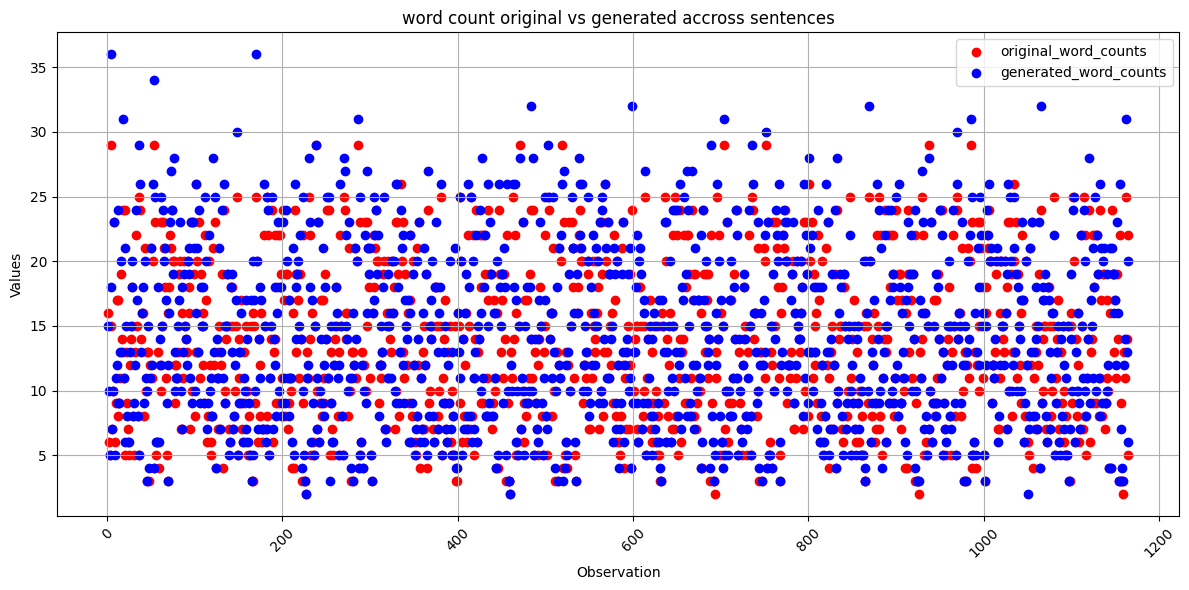

In [ ]:
plot_scatter_chart(df_results,['original_word_counts', 'generated_word_counts'],'word count original vs generated accross sentences')

In [ ]:
import seaborn as sns

def plot_violin_boxplots(df_results, column_names, title):
    plt.figure(figsize=(12, 6))


    sns.violinplot(data=df_results[column_names], inner="box", palette="Set3")

    plt.title(title)
    plt.xticks(range(len(column_names)), column_names)  # Adjusting the x-ticks
    plt.ylabel('Values')

    plt.tight_layout()
    plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/violin_boxplot_{title}.png")
    plt.show()


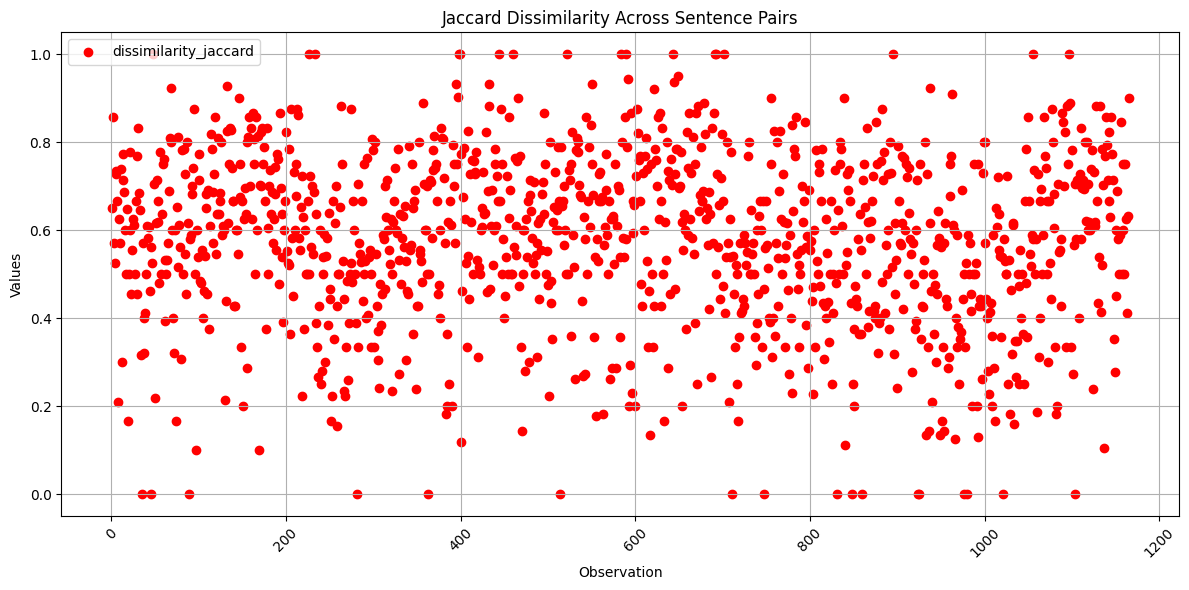

In [ ]:
plot_scatter_chart(df_results, 'dissimilarity_jaccard', 'Jaccard Dissimilarity Across Sentence Pairs')

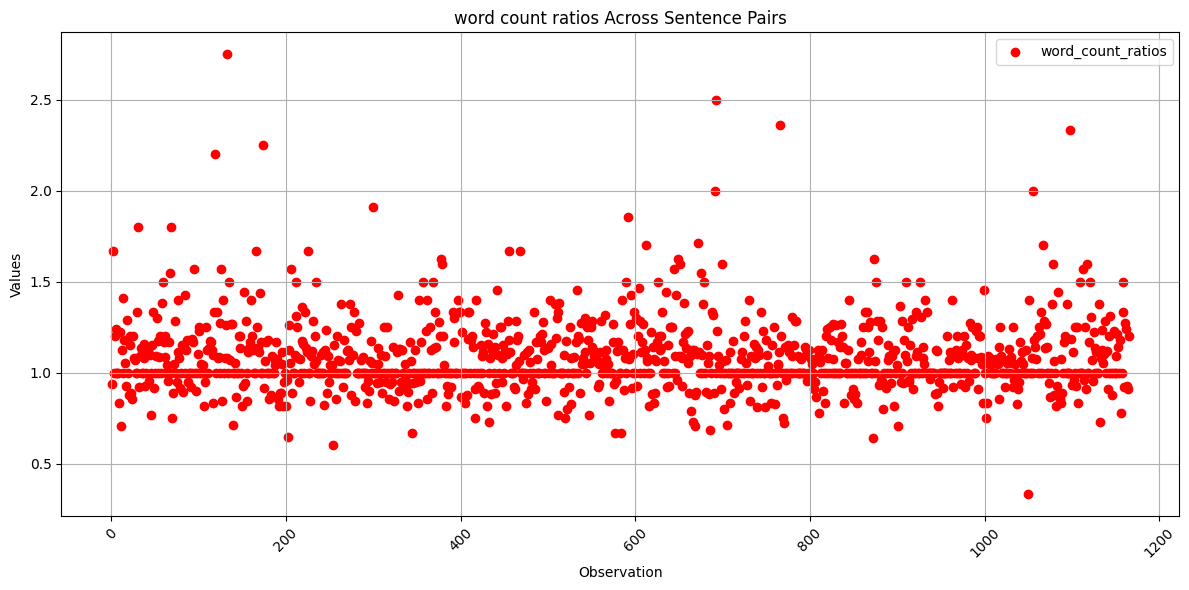

In [ ]:
plot_scatter_chart(df_results, 'word_count_ratios', 'word count ratios Across Sentence Pairs')


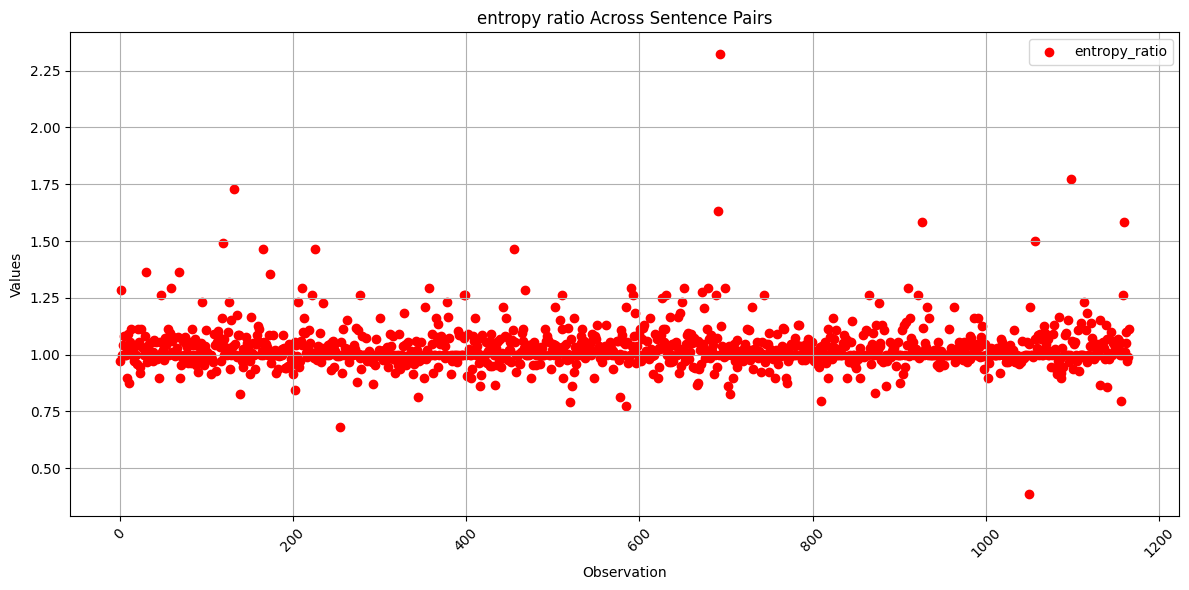

In [ ]:
plot_scatter_chart(df_results, 'entropy_ratio', 'entropy ratio Across Sentence Pairs')

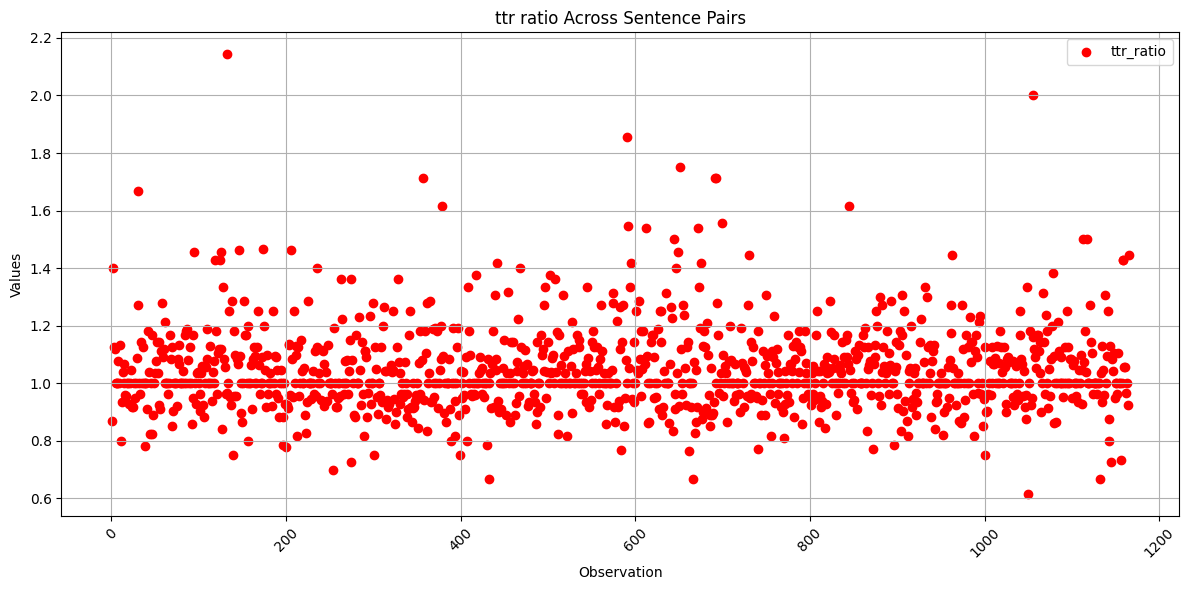

In [ ]:
plot_scatter_chart(df_results, 'ttr_ratio', 'ttr ratio Across Sentence Pairs')

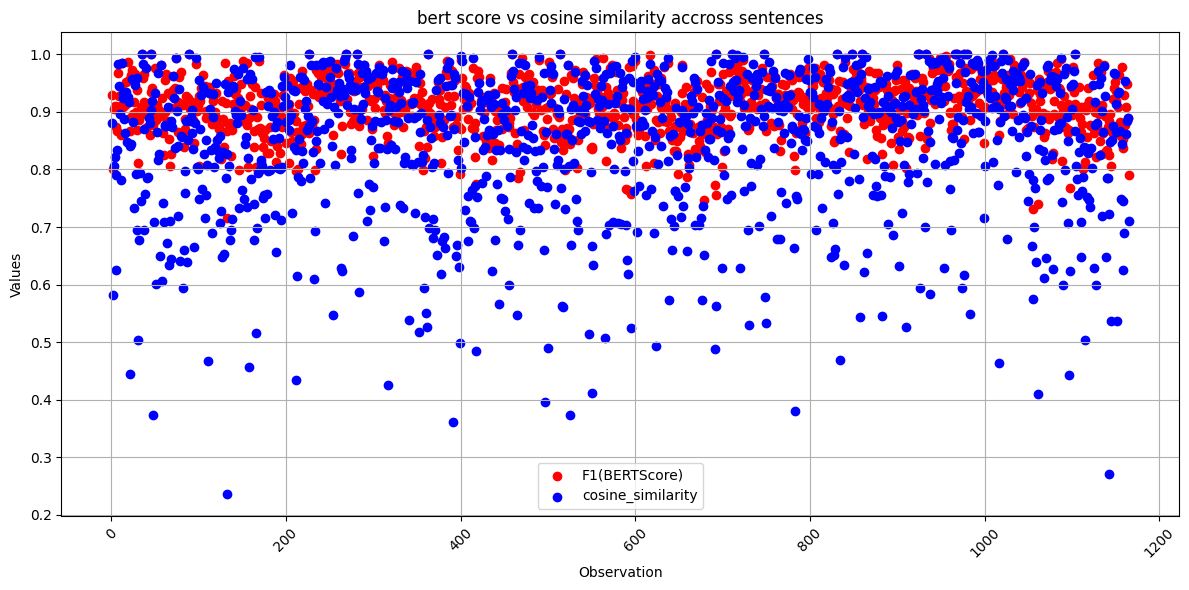

In [ ]:
plot_scatter_chart(df_results,['F1(BERTScore)', 'cosine_similarity'],'bert score vs cosine similarity accross sentences')

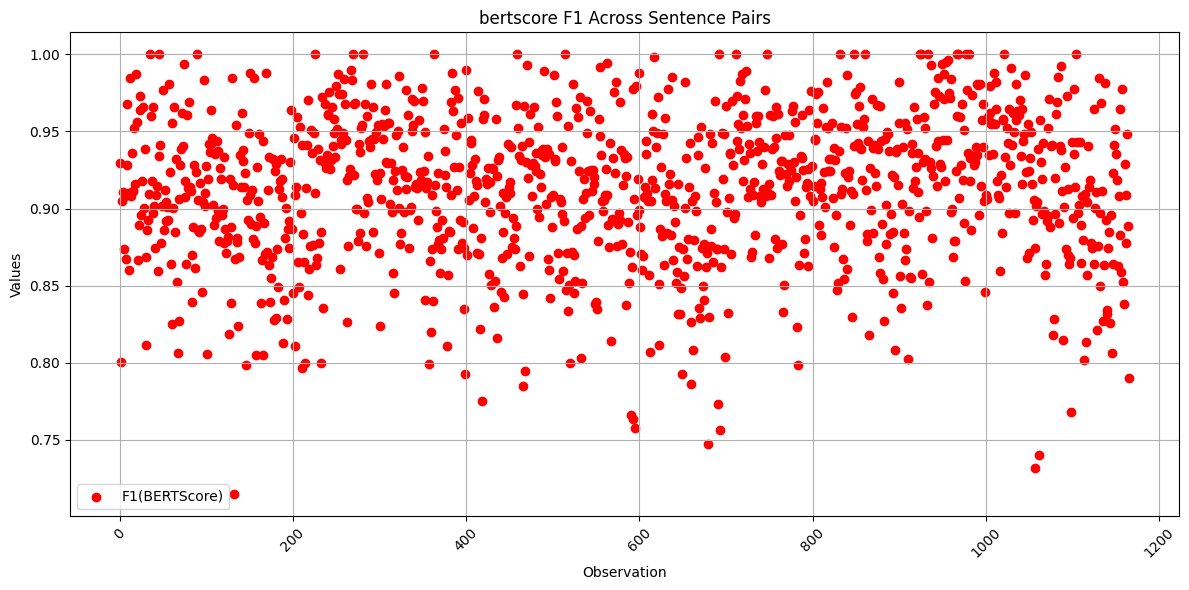

In [ ]:
plot_scatter_chart(df_results, 'F1(BERTScore)', 'bertscore F1 Across Sentence Pairs')

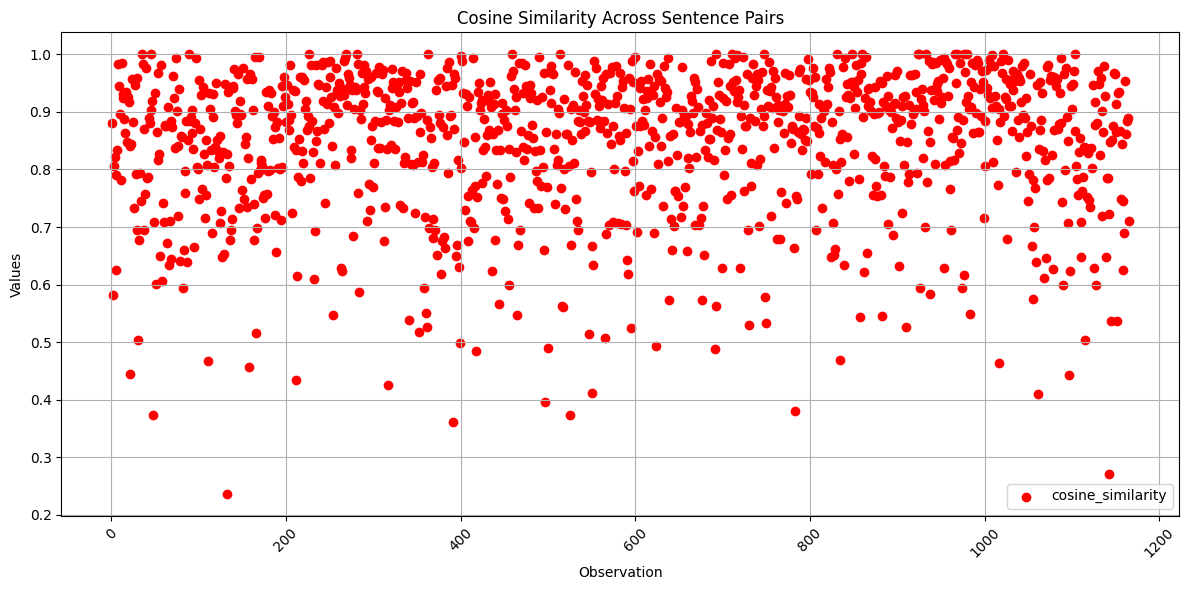

In [ ]:
plot_scatter_chart(df_results, 'cosine_similarity', 'Cosine Similarity Across Sentence Pairs')

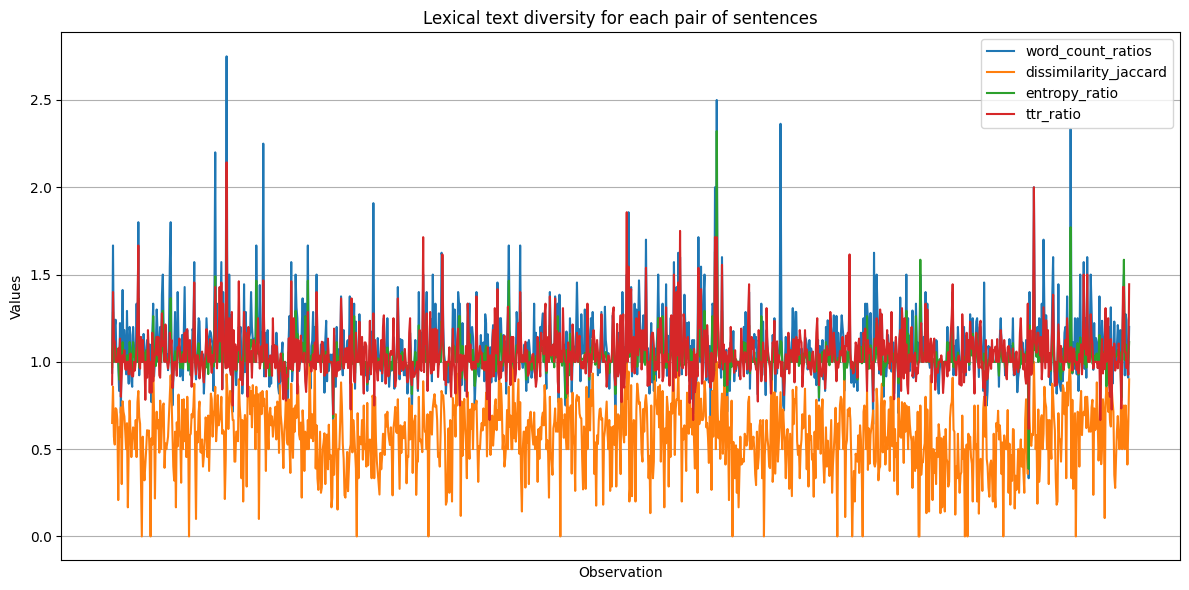

In [ ]:
plot_line_chart(df_results, ['word_count_ratios', 'dissimilarity_jaccard', 'entropy_ratio', 'ttr_ratio'],
                'Lexical text diversity for each pair of sentences')

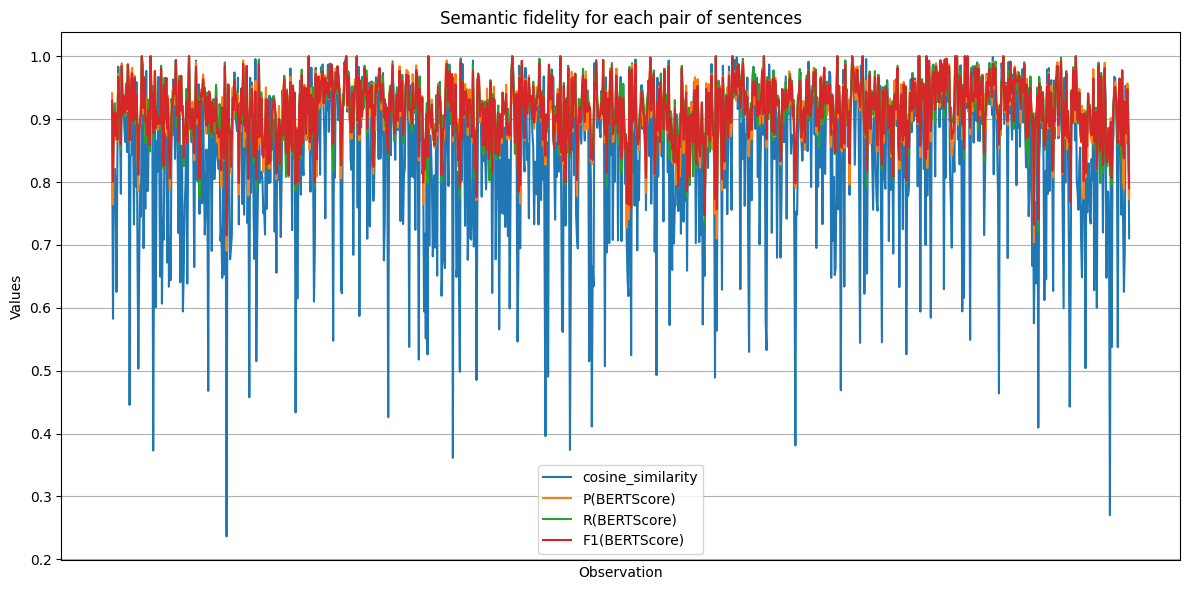

In [ ]:
plot_line_chart(df_results, ['cosine_similarity', 'P(BERTScore)', 'R(BERTScore)', 'F1(BERTScore)',]# 'euclidean_distance'],
                ,'Semantic fidelity for each pair of sentences')

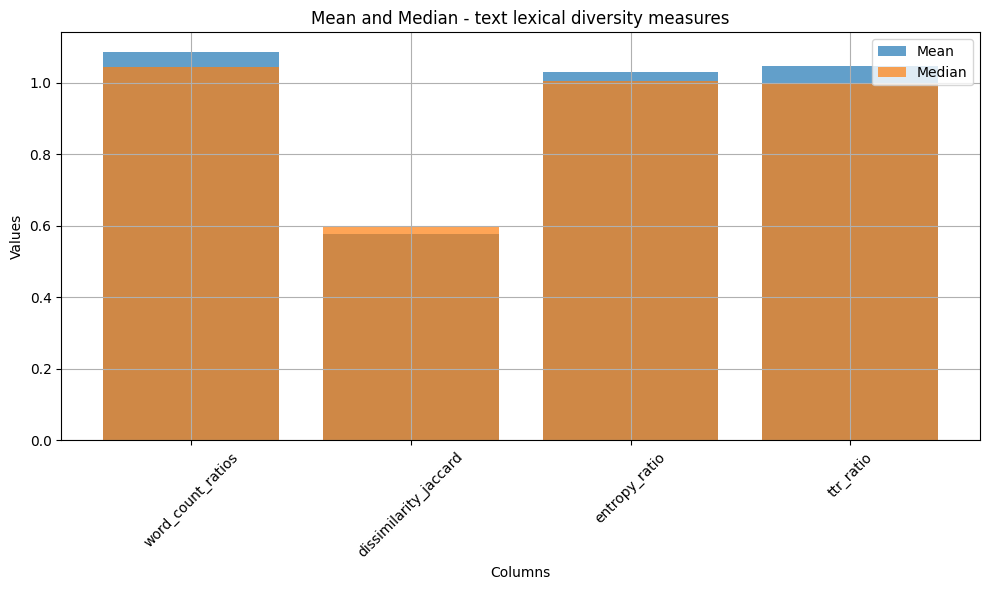

In [ ]:
plot_mean_and_median(df_results, ['word_count_ratios', 'dissimilarity_jaccard', 'entropy_ratio', 'ttr_ratio'],
                     'Mean and Median - text lexical diversity measures')

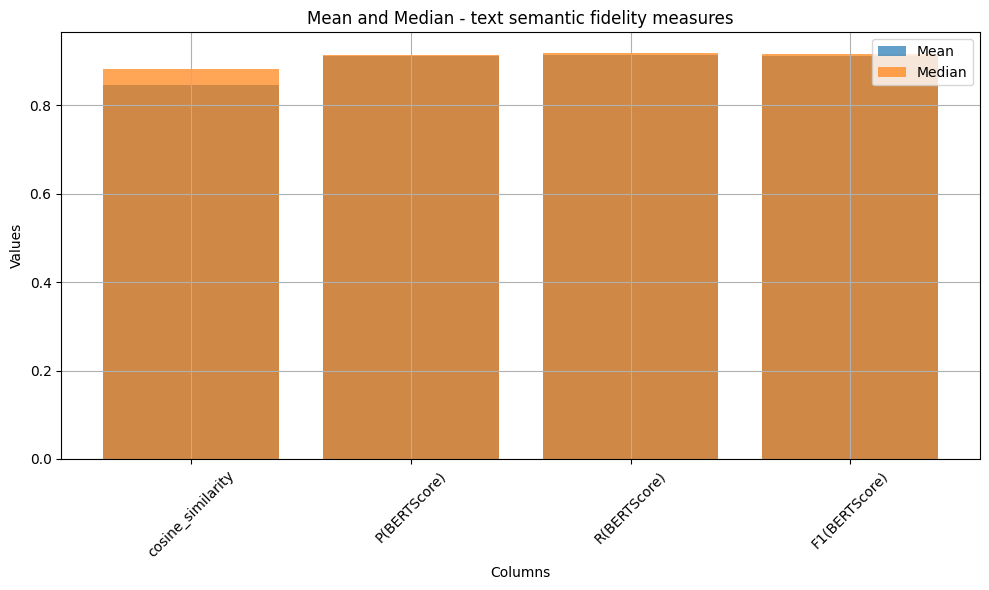

In [ ]:
plot_mean_and_median(df_results, ['cosine_similarity', 'P(BERTScore)', 'R(BERTScore)', 'F1(BERTScore)']#,'euclidean_distance'],
                      ,'Mean and Median - text semantic fidelity measures')

<Figure size 1000x600 with 0 Axes>

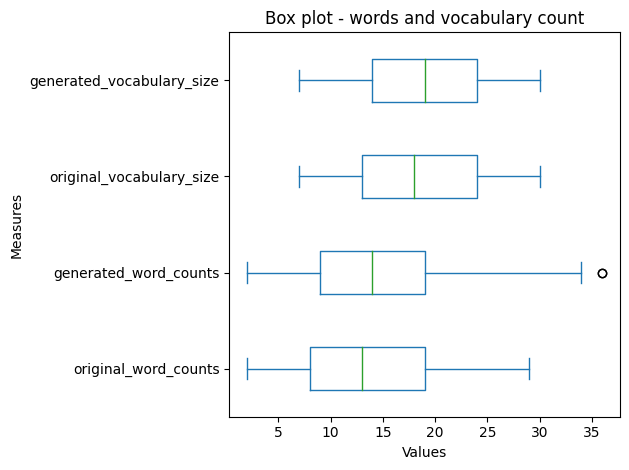

In [ ]:
plot_boxplot(df_results, ['original_word_counts', 'generated_word_counts', 'original_vocabulary_size', 'generated_vocabulary_size'],
             'Box plot - words and vocabulary count')


<Figure size 1000x600 with 0 Axes>

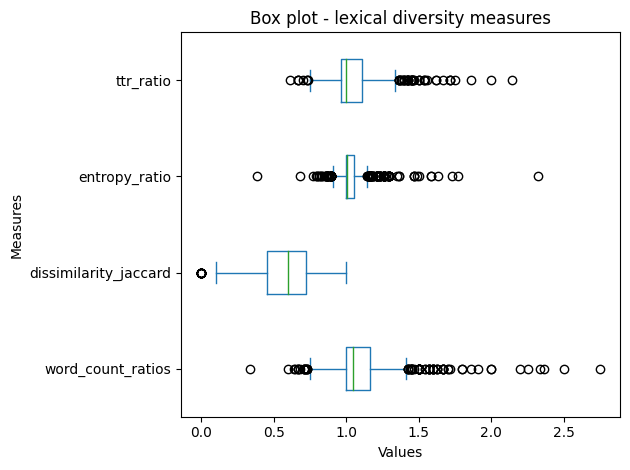

In [ ]:
plot_boxplot(df_results, ['word_count_ratios', 'dissimilarity_jaccard', 'entropy_ratio', 'ttr_ratio'],
             'Box plot - lexical diversity measures')

<Figure size 1000x600 with 0 Axes>

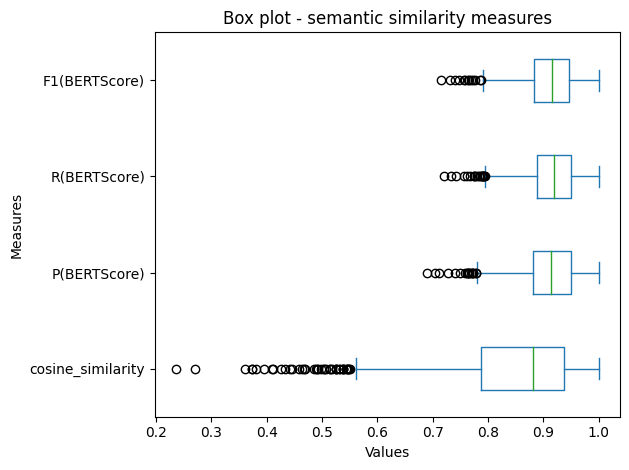

In [ ]:
plot_boxplot(df_results,['cosine_similarity',	'P(BERTScore)',	'R(BERTScore)',	'F1(BERTScore)',]# 'euclidean_distance'],
            ,'Box plot - semantic similarity measures')

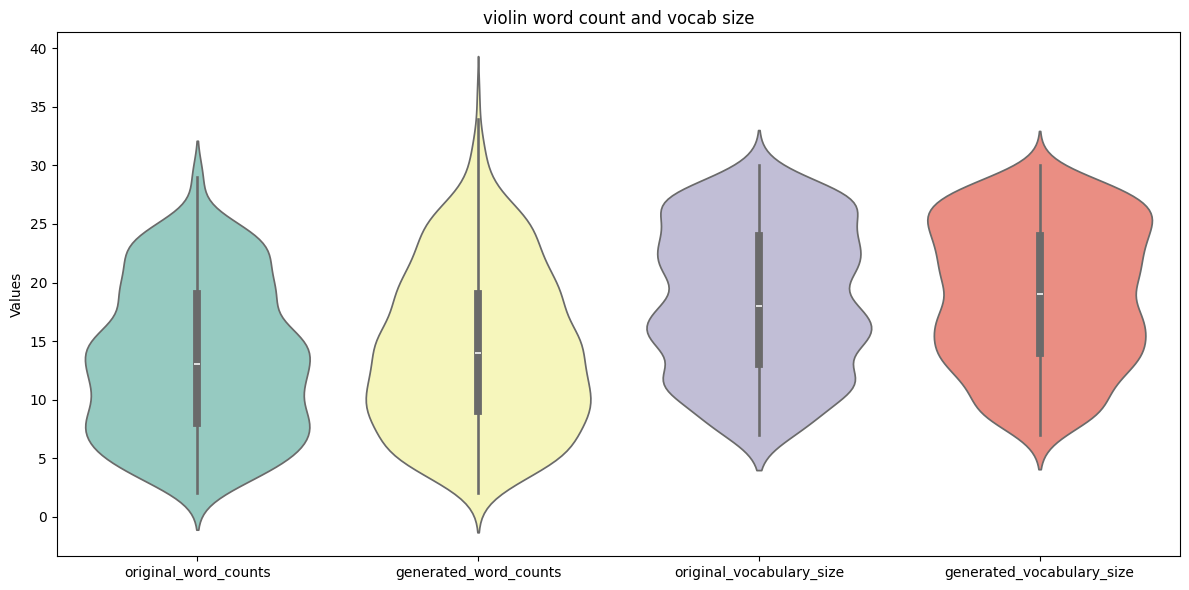

In [ ]:
plot_violin_boxplots(df_results, ['original_word_counts', 'generated_word_counts', 'original_vocabulary_size', 'generated_vocabulary_size'],'violin word count and vocab size')

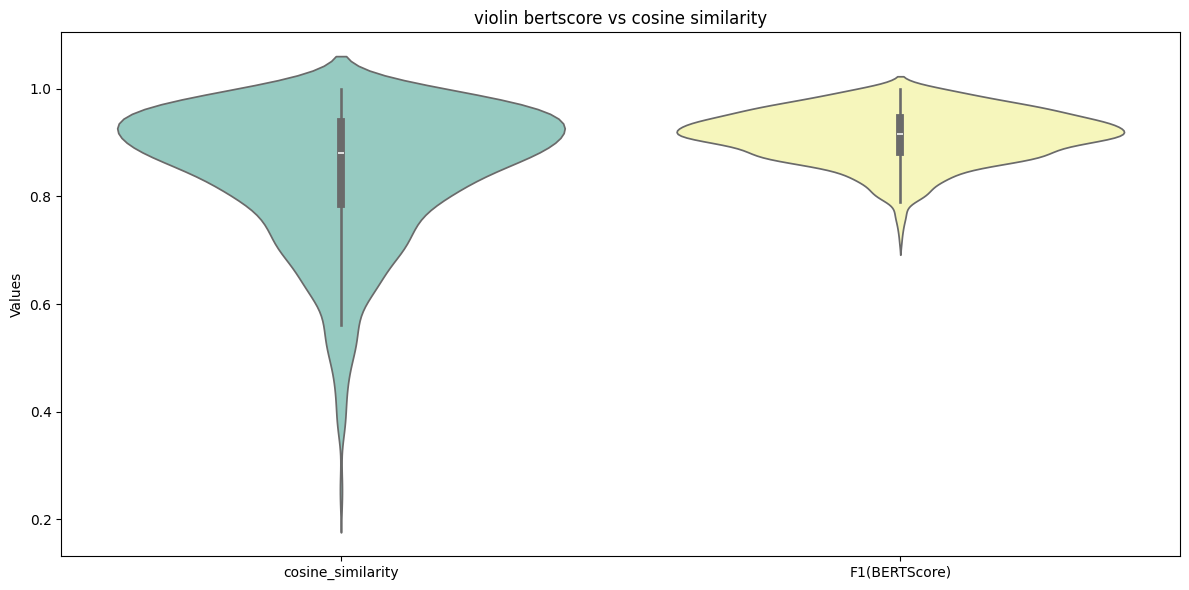

In [ ]:
plot_violin_boxplots(df_results, ['cosine_similarity','F1(BERTScore)'],'violin bertscore vs cosine similarity')

In [ ]:
##Uwagi
##jedna funckja do zapisywania i uruchamiania funkcji??
##zastanowic się jeszcze nad wykresami i typami wykresow... liniowy - zmienic?
## wykres  liniowy lub slupkowy pokazujacy wyniki (np srednie etc..) dla wybranej kategorii emocjii!!! trzeba by miec labele -- dodac gdzies

In [ ]:
log_message4 = "Measure results saved into csv format"
log_message5 = "Basic statistics saved into csv format"
log_message6 = "Plots (line chart, bar chart, boxplots) saved into .png format"

log = f"log4: {log_message4}\nlog5: {log_message5}\nlog6: {log_message6}"

with open(f"{path}{path_to_model}/text_evaluation/log.txt", "a") as log_file:
  log_file.write(log)

In [ ]:
##Threshold -- cutting data below???
##duplicates?

# def post_preprocess(generated_sentences_list, label_number, category):
#   df = pd.DataFrame(generated_sentences_list)
#   df = df.rename(columns={0:'text'})

#   df['labels'] = label_number ## add column with label number

#   duplicates = df.duplicated(subset=['text'], keep='first') ##check duplicates
#   global num_duplicates
#   num_duplicates = len(df[duplicates])
#   df = df.drop_duplicates(subset=['text'])
#   print(f'Dropped {num_duplicates} duplicates')

#   df.to_csv(f'Augmented_{category}_{len(generated_sentences_list)}_samples.tsv', sep='\t', index=False, header=False)

#(optional)Generated - only ZSL FSL evaluation

##load

In [ ]:
path = '/content/drive/MyDrive/results/'
path_to_model = 'distilbert_augmented24_gpt4/'

augmented_dataset_preprocessed_file_path = f'{path}/{path_to_model}/generated_text_preprocessed.tsv'
augmented_dataset_preprocessed = pd.read_csv(augmented_dataset_preprocessed_file_path, sep='\t', header=None)
print(len(augmented_dataset_preprocessed))

# reference_dataset = f'{path}{path_to_model}/reference_dataset.tsv'
# reference_dataset = pd.read_csv(reference_dataset, sep='\t',header=None)
# print(len(reference_dataset))

6743


In [ ]:
generated_text = augmented_dataset_preprocessed[0].tolist()

In [ ]:
generated_text = generated_text[::4]

##tokenize

In [ ]:
!pip install transformers
!pip install tokenizers

In [ ]:
#Let's tokenize orginal text sentences and generated text sentences
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize(text_list, tokenizer, max_length):
  tokenized = tokenizer(
      text_list,
      padding='max_length',
      max_length=max_length,
      truncation=True,
      return_tensors="tf"
  )
  return tokenized

max_length = 30
generated_text_tokenized = tokenize(generated_text, tokenizer, max_length)

##lexical diversity

In [ ]:
def calculate_word_counts(generated_sentence):
    generated_word_counts = len(generated_sentence.split())
    return generated_word_counts

# for original, generated in zip(original_text, generated_text):
#   original_word_counts,generated_word_counts, word_count_ratios =  calculate_word_counts_and_ratios(original, generated)
#   print(f"Original-Word Count: {original_word_counts}, Generated-Word Count: {generated_word_counts}, Word Count Ratio (Generated/Original): {word_count_ratios:.2f}")
#   print()


In [ ]:
def zsl_fsl_calculate_ttr(generated_text_tokenized, index):
    generated_tokens = np.array(generated_text_tokenized["input_ids"][index])
    generated_vocabulary_size = len(set(generated_tokens)) ##unique tokens length
    generated_ttr = generated_vocabulary_size / len(generated_tokens)
    return  generated_vocabulary_size, generated_ttr


# for i in range(len(original_text_tokenized["input_ids"])):
#     ttr_ratio, original_vocabulary_size, generated_vocabulary_size = calculate_ttr(original_text_tokenized, generated_text_tokenized, i)
#     print(f"Sentence Pair {i+1} - TTR Ratio: {ttr_ratio:.2f}, orginal - Vocab size: {original_vocabulary_size}, generated - Vocab size: {generated_vocabulary_size}")

##save results

In [ ]:
##lexcial diversity function

from statistics import mean, median


def zsl_fsl_save_lexical_diversity_results(generated_text, filename):
  header = ['generated text','generated_word_counts','generated_vocabulary_size', 'generated_ttr']
  generated_word_count_list = []; generated_ttr_list = []; generated_vocabulary_size_list = []
  i=0

  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)


    for generated in generated_text:
      generated_word_counts = calculate_word_counts(generated)
      generated_word_count_list.append(generated_word_counts)

      generated_vocabulary_size, generated_ttr = zsl_fsl_calculate_ttr(generated_text_tokenized, i)

      i+=1
      generated_vocabulary_size_list.append(generated_vocabulary_size)
      generated_ttr_list.append(generated_ttr)

      writer.writerow([generated, generated_word_counts, generated_vocabulary_size, generated_ttr])

    return generated_word_count_list, generated_vocabulary_size_list, generated_ttr_list

In [ ]:
diversity_filename=f'{path}{path_to_model}text_evaluation/lexical_diversity_results.csv'
generated_word_count_list, generated_vocabulary_size_list, generated_ttr_list = zsl_fsl_save_lexical_diversity_results(generated_text, diversity_filename)

avg_word_generated_count = mean(generated_word_count_list)
avg_generated_vocabulary_size = mean(generated_vocabulary_size_list)
avg_generated_ttr_ratio = mean(generated_ttr_list)

In [ ]:
def preprocess(diversity_filename):

  df_results_diversity_zsl_fsl = pd.read_csv(diversity_filename)


  df_results_diversity_zsl_fsl.reset_index(drop=True, inplace=True)

  return df_results_diversity_zsl_fsl

In [ ]:
# ##calculate basic stats
# def calc_stats(df_results):
#   basic_statistics = df_results.describe() ##gather statistics (mean, std, median, mode, max, min,...)
#   for column in df_results.columns[2:]:
#     mode_value = df_results[column].mode()
#     basic_statistics.at['mode', column] = mode_value[0] ##dodanie - dominanta czy potrzebna???

#   df_stats = pd.DataFrame(basic_statistics)
#   df_stats.to_csv(f'{path}{path_to_model}text_evaluation/basic_statistics_results.csv', index = False)

#   return df_stats

In [ ]:
df_results = preprocess(diversity_filename)
# df_stats = calc_stats(df_results)

In [ ]:
##average results:

avg_results = {
    'Avg Word Count Generated': round(avg_word_generated_count, 4),
    'Avg vocab size': round(avg_generated_vocabulary_size, 4),
    'Avg TTR Ratio': round(avg_generated_ttr_ratio, 4),
}

df_avg_results=pd.DataFrame([avg_results])
df_avg_results.to_csv(f'{path}{path_to_model}text_evaluation/avg_results.csv', index = False)

In [ ]:
##BLEU for FSL...

In [ ]:
df_results

,generated text,generated_word_counts,generated_vocabulary_size,generated_ttr
0,My heart is heavy and it feels like it's been ...,13,20,0.666667
1,"Often, I look to the sky on starless nights, y...",17,23,0.766667
2,"Sometimes when I laugh, it abruptly turns into...",17,21,0.700000
3,Their absence has created a deep void in my he...,16,21,0.700000
4,"Day and night, memories of them haunt me; they...",15,23,0.766667
...,...,...,...,...
1681,"Blushing so hard, I could double as a tomato.",9,14,0.466667
1682,Couldn't the earth just swallow me whole right...,9,15,0.500000
1683,"Bruh, my cheeks are burning with sheer embarra...",8,14,0.466667
1684,"This is the epitome of cringe, I want to dig a...",15,23,0.766667


##plots zsl fsl

In [ ]:
def zsl_fsl_plot_line_chart(df_results, column_names, title ):
  plt.figure(figsize=(12, 6))
  custom_labels = [f'Sentence Pair {i + 1}' for i in range(len(df_results))]

  for col in column_names:
      plt.plot(custom_labels, df_results[col], label=col)

  plt.title(title)
  plt.xlabel('Observation')
  plt.ylabel('Values')
  plt.legend()
  plt.grid(True)
  plt.xticks(ticks=[], labels=[])# Hides specific x-axis labels
  plt.tight_layout()
  plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_line_chart_{title}.png")
  plt.show()

In [ ]:
def zsl_fsl_plot_mean_and_median(df_results, column_names, title):
  mean_values = df_results[column_names].mean()
  median_values = df_results[column_names].median()

  plt.figure(figsize=(10, 6))
  plt.bar(column_names, mean_values, label='Mean', alpha=0.7)
  plt.bar(column_names, median_values, label='Median', alpha=0.7)
  plt.title(title)
  plt.xlabel('Columns')
  plt.ylabel('Values')
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_mean_and_median_{title}.png")
  plt.show()

In [ ]:
def zsl_fsl_plot_scatter_chart(df, column_names, title):
    plt.figure(figsize=(12, 6))

    if isinstance(column_names, list):
        colors = ['red', 'blue']  # Define more colors if you expect more columns
        for i, column_name in enumerate(column_names):
            plt.scatter(df.index + 1, df[column_name], color=colors[i], label=column_name)
    else:
        plt.scatter(df.index + 1, df[column_names], color='red', label=column_names)

    plt.title(title)
    plt.xlabel('Observation')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/plot_scatter_chart_{title}.png")
    plt.show()

In [ ]:
import seaborn as sns

def zsl_fsl_plot_violin_boxplots(df_results, column_names, title):
    plt.figure(figsize=(12, 6))


    sns.violinplot(data=df_results[column_names], inner="box", palette="Set3")

    plt.title(title)
    plt.xticks(range(len(column_names)), column_names)  # Adjusting the x-ticks
    plt.ylabel('Values')

    plt.tight_layout()
    plt.savefig(f"{path}{path_to_model}/text_evaluation/plots/violin_boxplot_{title}.png")
    plt.show()


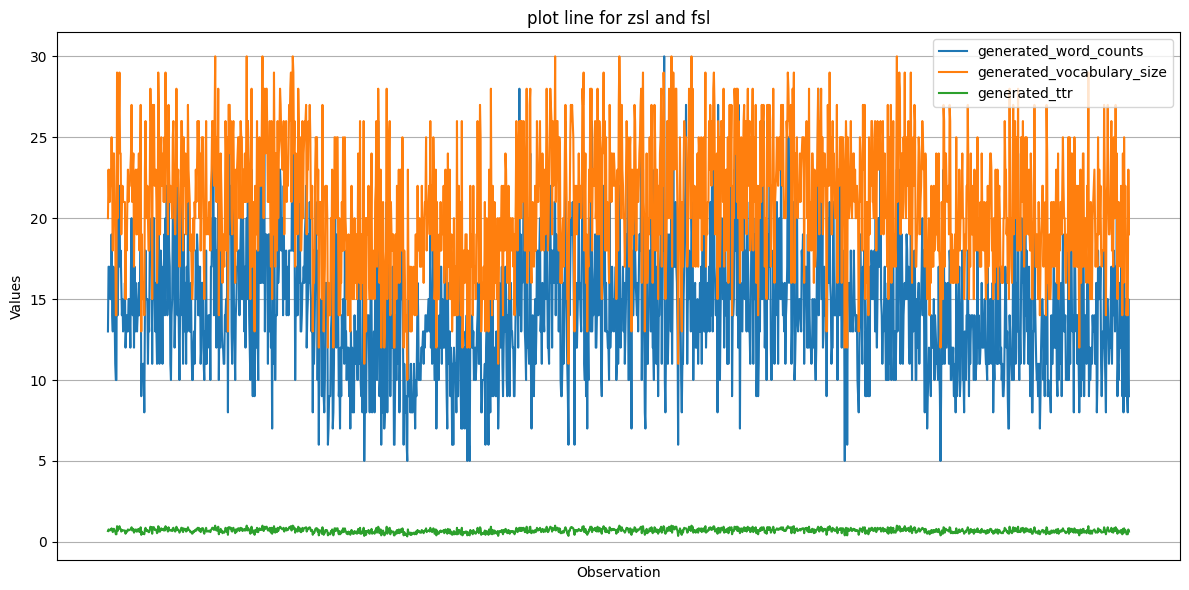

In [ ]:
zsl_fsl_plot_line_chart(df_results, ['generated_word_counts','generated_vocabulary_size', 'generated_ttr'],'plot line for zsl and fsl')

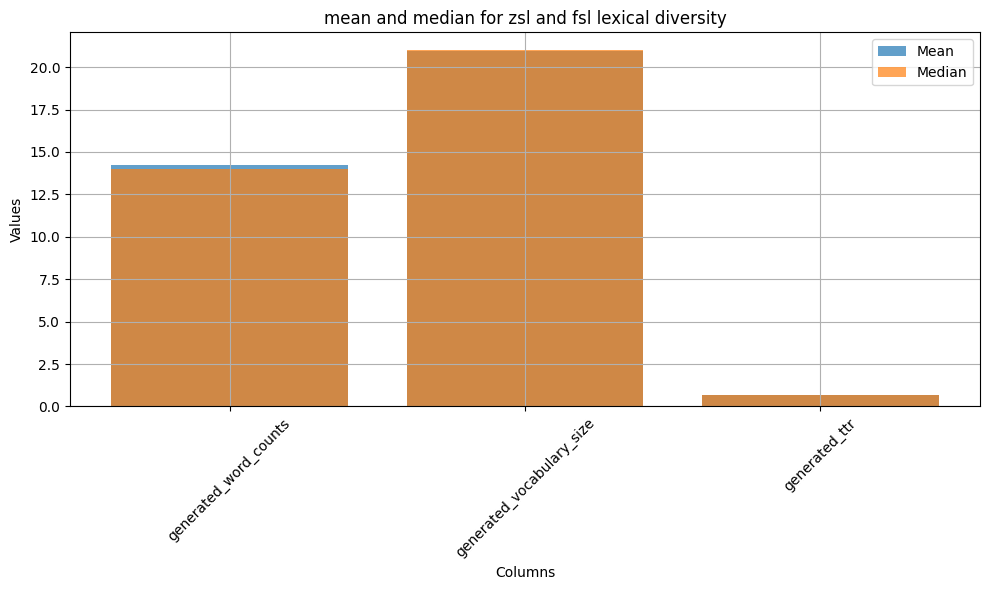

In [ ]:
zsl_fsl_plot_mean_and_median(df_results,['generated_word_counts','generated_vocabulary_size', 'generated_ttr'], 'mean and median for zsl and fsl lexical diversity')

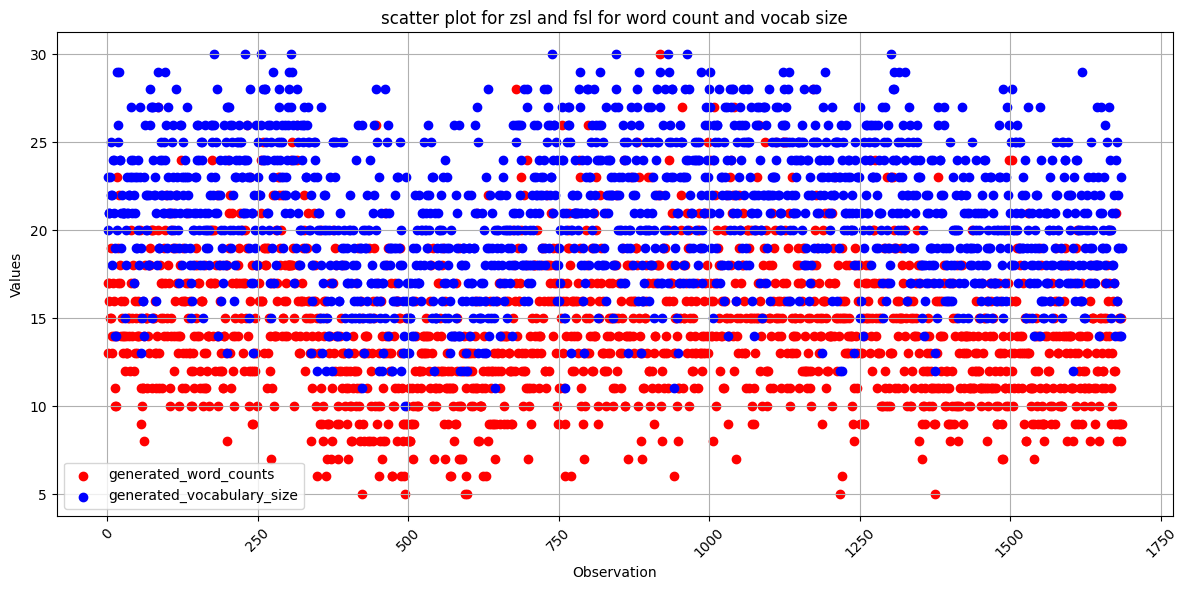

In [ ]:
zsl_fsl_plot_scatter_chart(df_results, ['generated_word_counts','generated_vocabulary_size'], 'scatter plot for zsl and fsl for word count and vocab size')

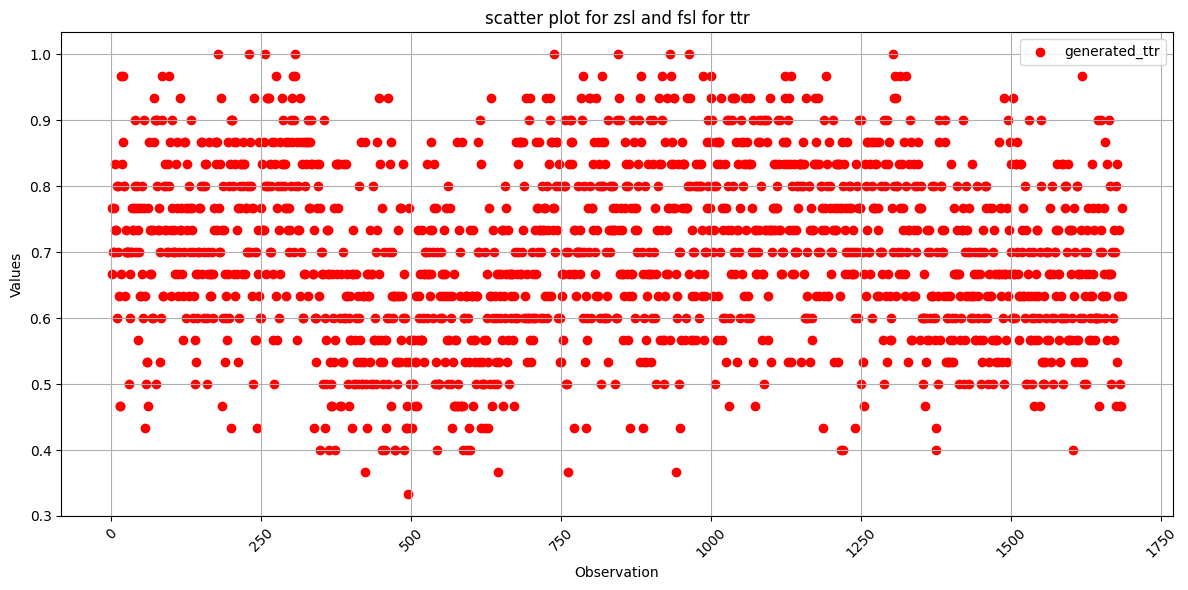

In [ ]:
zsl_fsl_plot_scatter_chart(df_results, 'generated_ttr', 'scatter plot for zsl and fsl for ttr')

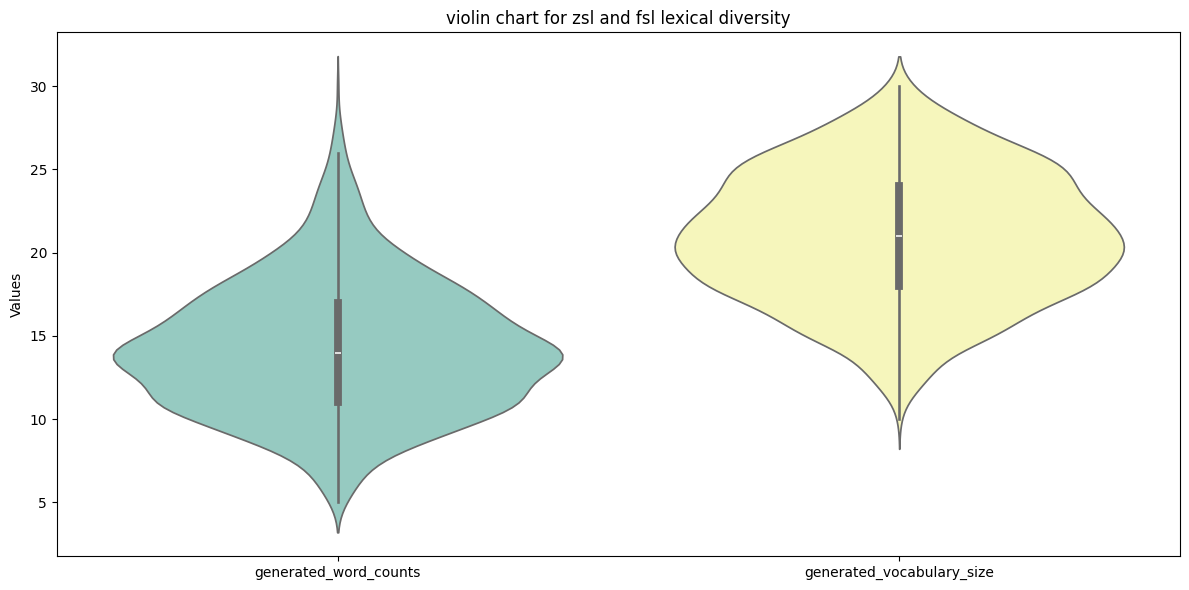

In [ ]:
zsl_fsl_plot_violin_boxplots(df_results,['generated_word_counts','generated_vocabulary_size'], 'violin chart for zsl and fsl lexical diversity')

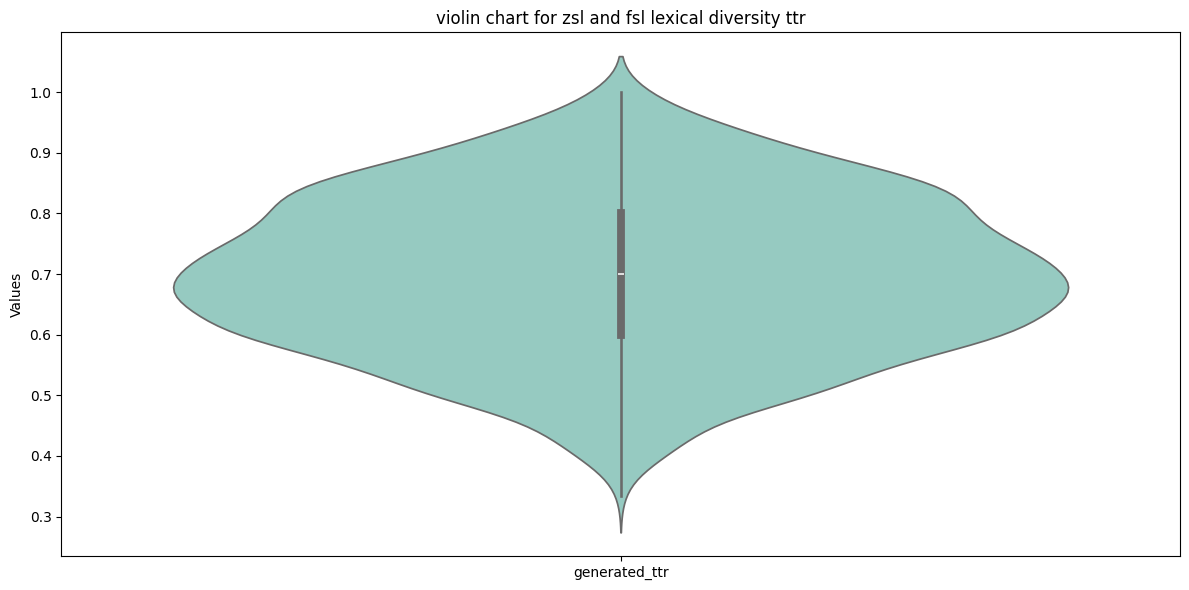

In [ ]:
zsl_fsl_plot_violin_boxplots(df_results, ['generated_ttr'], 'violin chart for zsl and fsl lexical diversity ttr')